# Example: second harmonic generation in waveguides


Author: Luis Ledezma (ledezma@caltech.edu)

## The code

We begin by importing the modules needed, including my own. I also do some formatting. You can safely ignore all this.

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
from matplotlib import cm
import colorcet as cc
from scipy import signal

#This are my libraries
import snlo.nlo as nlo 
import snlo.pulses as pulses
import snlo.materials as materials
import snlo.waveguides as waveguides

#Larger font for plots
plt.rcParams.update({'font.size': 18})

## Units
We'll work in SI base units for the most part. Here we load some constants and also create some variables for scaling units conveniently.

In [2]:
from scipy.constants import pi, c, epsilon_0
nm = 1e-9
um = 1e-6
mm = 1e-3
ps = 1e-12
fs = 1e-15
GHz = 1e9
THz = 1e12
pJ = 1e-12
fJ = 1e-15
mW = 1e-3

## Time and Frequency domain windows

### General Comments
We need to determine the FFT size $N$, as well the size of the time window $T$ and the total frequency bandwidth $F_\mathrm{BW}$. Both domain will have $N$ points, and these three parameters are related by the uncertainty relations:

$${\Delta t} {\Delta f } = \frac{1}{N}, \\
T F_{\mathrm{BW}} = N.$$

In [3]:
wl_ff = 2090*nm #Fundamental wavelength
f0_ff = c/wl_ff
wl_sh = wl_ff/2

#Let's set the bandwdith to LN transparency window or so
f_max = c/(800*nm)
f_min = c/(3.0*um)
BW = f_max - f_min 

#Now we can create the time and frequency arrays
NFFT = 2**9
Tmax = NFFT/BW
dt = 1/BW
t_start = -Tmax/2
t_stop = t_start + NFFT*dt
t = np.arange(t_start, t_stop, step=dt)
f = fftfreq(NFFT, dt)
Omega = 2*pi*f
df = f[1]-f[0]

We also need to choose a reference frequency $f_{ref}$. Our simulation is a bandpass simulation centered around this reference frequency. So, the natural frequency variable for our simulation is $$\Omega = \omega - \omega_{ref}.$$

In [4]:
#Reference frequency
f_ref = (f_min + f_max)/2
wl_ref = c/f_ref
omega_ref = 2*pi*f_ref

#Absolute frequencies and wavelengths
f_abs = f + f_ref
wl_abs = c/f_abs
omega_abs = 2*pi*f_abs
f_min = np.amin(f_abs)
f_max = np.amax(f_abs)
wl_max = c/f_min
wl_min = c/f_max

print('Fundamental wavelength = %0.1f nm' %(wl_ff/nm))
print('Fundamental frequency = %0.1f THz' %(f0_ff/THz))
print('Simulation bandwidth = %0.1f THz' %(BW/THz))
print('Time window size = %0.3f ps' %(Tmax/ps))
print('Sampling Rate = %0.3f fs' %(dt/fs))
print('Frequency Resolution = %0.3f GHz' %(df/GHz))
print('Reference wavelength = %0.1f nm' %(wl_ref/nm))
print('Reference frequency = %0.1f THz' %(f_ref/THz))
print('Minimum absolute frequency = %0.1f THz' %(f_min/THz))
print('Maximum absolute frequency = %0.1f THz' %(f_max/THz))
print('Minimum absolute wavelength = %0.1f nm' %(c/f_max/nm))
print('Maximum absolute wavelength = %0.1f um' %(c/f_min/um))

Fundamental wavelength = 2090.0 nm
Fundamental frequency = 143.4 THz
Simulation bandwidth = 274.8 THz
Time window size = 1.863 ps
Sampling Rate = 3.639 fs
Frequency Resolution = 536.738 GHz
Reference wavelength = 1263.2 nm
Reference frequency = 237.3 THz
Minimum absolute frequency = 99.9 THz
Maximum absolute frequency = 374.2 THz
Minimum absolute wavelength = 801.1 nm
Maximum absolute wavelength = 3.0 um


In [5]:
(3*f_max - f_min)/BW #Try to keep it below 4

3.721413352272728

## Material and Waveguide properties

I'm going to load the refractive index of lithium tantalate from my personal library named <font color=magenta> materials</font>. In that library I implement mostly Sellmeier's equations obtained from https://refractiveindex.info/ for a few common materials.

In [6]:
width = 1800*nm
hLN = 700*nm
hetch = 350*nm
wg = waveguides.waveguide(w_top=width, h_ridge=hLN, h_slab=hLN-hetch, tf_material = 'LN_MgO_e',
                         box_material = 'SiO2',  clad_material = 'Air')
wg.add_narray(wl_abs)

Refractive index at fundamental = 1.855
Refractive index at second harmonic = 2.056
Poling period for second harmonic generation starting at 2.090 um = 5.1819 um


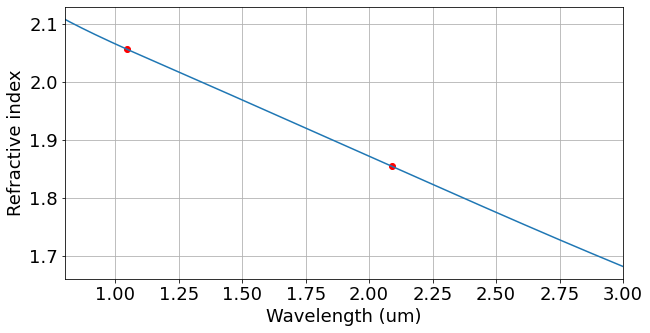

In [7]:
n = wg.neff_array
nw = wg.neff(wl_ff)
n2w = wg.neff(wl_sh)

plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(fftshift(wl_abs/um), fftshift(n))
ax1.scatter(wl_ff/um, nw, c='r')
ax1.scatter(wl_sh/um, n2w, c='r')
ax1.set_xlim([wl_min/um, wl_max/um])
ax1.set_xlabel('Wavelength (um)')
ax1.set_ylabel('Refractive index')
ax1.grid(True)

print('Refractive index at fundamental = %0.3f' %(nw))
print('Refractive index at second harmonic = %0.3f' %(n2w))

pp = (wl_sh)/(n2w-nw)
print("Poling period for second harmonic generation starting at %0.3f um = %0.4f um" %(wl_ff/um, pp/um))

Now we'll get the propagation constant as usual:
$$ \beta = \frac{\omega n}{c} ,$$

as well as the group velocity and GVD:
$$ 
v_g = \frac{1}{\beta_1} = \left( \frac{\partial \beta}{\partial \omega} \right)^{-1} \\
\mathrm{GVD} = \beta_2 = \frac{\partial^2 \beta}{\partial \omega^2} .
$$

We also need to get the higher order dispersion operator; this can be obtained from the propagation constant as follows:
$$D = \beta(\Omega) - \beta \big|_{\Omega=0} - \frac{\Omega}{v_{ref}}.$$

For this example we'll use $v_{ref} = v_g(2 \omega_0)$.

At this point we can also compute the GVM ($\Delta \beta^\prime $) between the fundamental signal and the moving reference frame:
$$ \Delta \beta^\prime = \frac{1}{v_{ref}} - \frac{1}{v_g(\omega_0)}, $$
and then we can compute how much a pulse at $\omega_0$ will travel in a crystal of length $L$,
$$ \tau =  L \Delta \beta^\prime. $$

GVM between 2090.0 nm and 1045.0 nm = -2.9591 fs/mm
GVD at 2090.0 nm = 28.9 fs^2/mm
GVD at 1045.0 nm = 118.6 fs^2/mm


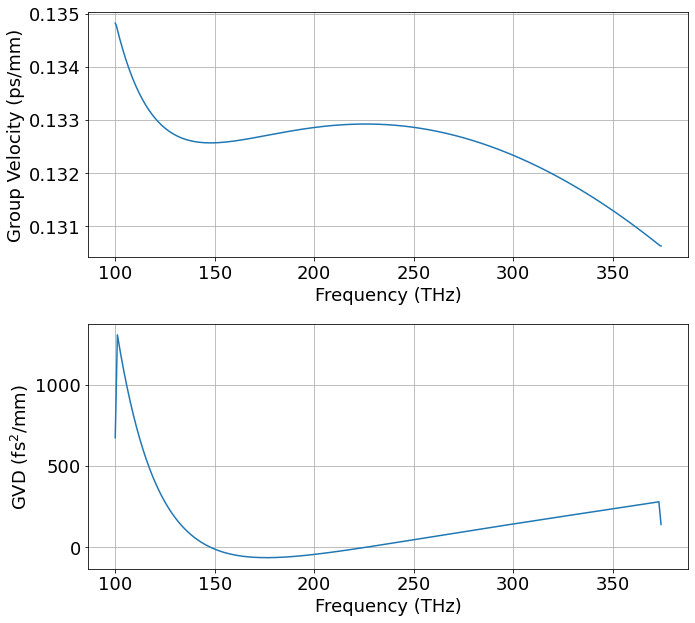

In [8]:
beta_2 = fftshift(np.gradient(fftshift(wg.beta_1), 2*pi*df))
v_ref = 1/wg.beta1(wl_sh)

# beta = omega_abs*n/c
# beta_1 = 
# beta_1 = fftshift(np.gradient(fftshift(beta), 2*pi*df))
# vg = 1/beta_1
# beta_ref = beta[0]
# f_v_ref = 2*f0_ff
# f_v_ref_index = np.abs(f + f_ref - f_v_ref).argmin()
# v_ref = vg[f_v_ref_index]
# D = beta - beta_ref - Omega/v_ref
# GVM = 1/v_ref - 1/vg

plt.rcParams['figure.figsize'] = [10, 9]
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(fftshift(f_abs)/THz, fftshift(1/wg.beta_1)/(mm/ps));
ax1.set_ylabel('Group Velocity (ps/mm)'); ax1.set_xlabel('Frequency (THz)');

ax2.plot(fftshift(f_abs)/THz, fftshift(beta_2)/(fs**2/mm));
ax2.set_ylabel('GVD (fs$^2$/mm)'); ax2.set_xlabel('Frequency (THz)');

ax1.grid(True); ax2.grid(True);
plt.tight_layout()

f0_sh_index = np.abs(f + f_ref - 2*f0_ff).argmin()
gvm_shg = wg.beta1(wl_ff) - wg.beta1(wl_sh)
print('GVM between %0.1f nm and %0.1f nm = %0.4f fs/mm' %(wl_ff/nm, wl_sh/nm, gvm_shg/(fs/mm)) ) 

print('GVD at %0.1f nm = %0.1f fs^2/mm' %(wl_ff/nm, wg.GVD(wl_ff)/(fs**2/mm) ) )
print('GVD at %0.1f nm = %0.1f fs^2/mm' %(wl_sh/nm, wg.GVD(wl_sh)/(fs**2/mm) ) )

## Adding nonlinearity and QPM to the waveguide

In [9]:
L = 4*mm

Alpha = 0.1 # attentuation coefficient (dB/cm)
alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m

def poling_func(z):
    return np.sign(np.cos(z*2*pi/pp))

wg.add_poling(poling_func)
wg.set_nonlinear_coeffs(N = 1, X0 = 1.1e-12)
# wg.set_nonlinear_coeffs(N = 1, X0 = 0)
wg.set_length(L)
wg.set_loss(alpha)

## Input pulse creation

Here I introduce a class named ```pulse```, the goal is to pack everything relevant to the pulse into a single object, just like we did with ```nonlinear_element```. I also have a bunch of convenience methods associated with ```pulse``` for things like plotting, calculating FWHM, energy, etc.

Pulse Energy = 0.106 pJ
Peak Power = 1.000 W


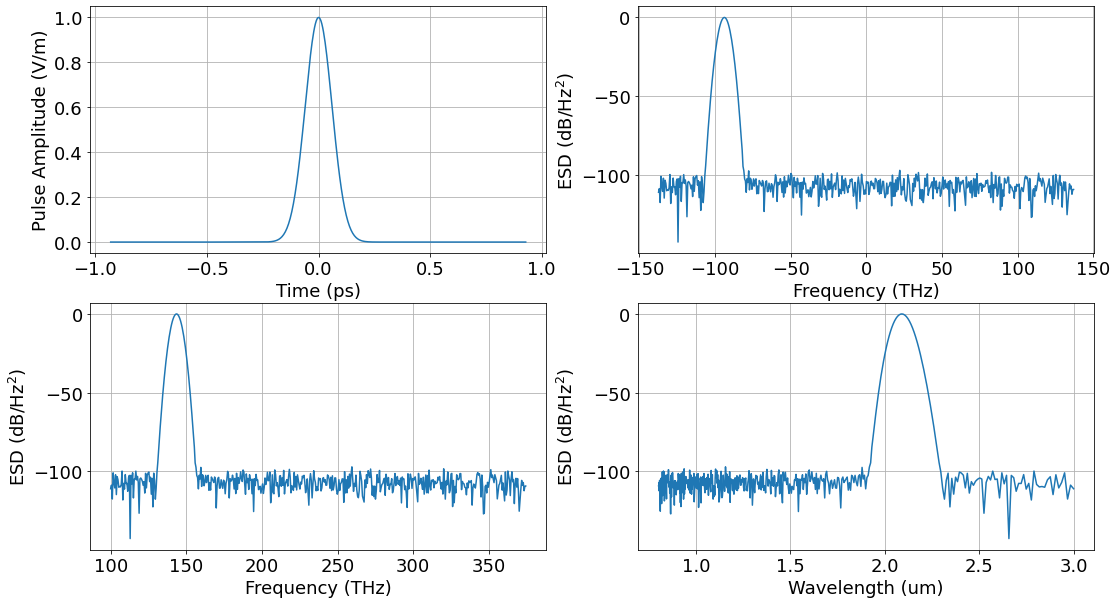

In [10]:
#Pulse width:
tau = 100*fs

#Peak power:
Ppeak = 1

#Pulse creation
N_dB = 100
pump = pulses.gaussian_pulse(t, tau, Ppeak=Ppeak, f_ref=f_ref, f0=f0_ff, Npwr_dB=N_dB)
# pump = pulses.sech_pulse(t, tau, Ppeak=Ppeak, f_ref=f_ref, f0=f0_ff, Npwr_dB=-N_dB)

print('Pulse Energy = %0.3f pJ' %(pump.energy_td()/pJ))
print('Peak Power = %0.3f W' %( np.amax(np.abs(pump.a)**2) ))

plt.rcParams['figure.figsize'] = [18, 10]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1 = pump.plot_mag(ax=ax1, t_unit='ps'); ax1.set_ylabel('Pulse Amplitude (V/m)')
ax2 = pump.plot_ESD_dB(ax=ax2, label='ESD (dB/Hz$^2$)', f_unit = 'THz')
ax3 = pump.plot_ESD_dB_absfreq(ax=ax3, label='ESD (dB/Hz$^2$)', f_unit = 'THz')
ax4 = pump.plot_ESD_dB_vs_wavelength(ax=ax4, label='ESD (dB/Hz$^2$)', wl_unit='um');

## Single pass

Finally, we can run the simulation. The method ```propagate_NEE``` takes a pulse object, a step size, and a reference velocity for the moving frame and outputs a pulse and it's evolution along the crystal.

In [11]:
h = pp/10 #Step size
[a_out, pulse_evol_full] = wg.propagate_NEE(pump, h, v_ref=v_ref, zcheck_step = 1*mm)

Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7719
Completed propagation along 1.00 mm (1.2 s)
Completed propagation along 2.00 mm (1.1 s)
Completed propagation along 3.00 mm (1.1 s)
Completed propagation along 4.00 mm (1.1 s)
Total time = 4.7 s


In [12]:
print('Input pulse energy = %0.3f pJ' %(pump.energy_td()/pJ))
print('Output pulse energy = %0.3f pJ' %(a_out.energy_td()/pJ))

Input pulse energy = 0.106 pJ
Output pulse energy = 0.105 pJ


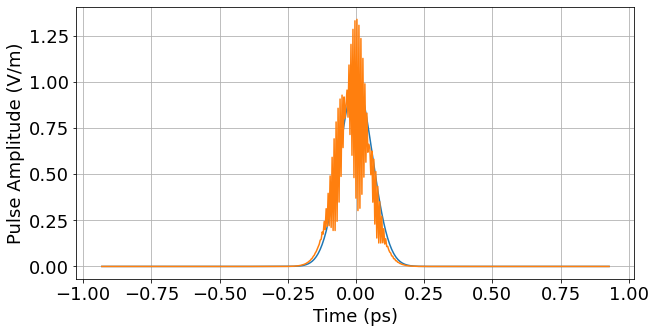

In [13]:
plt.rcParams['figure.figsize'] = [10, 5]
ax1 = pump.plot_mag()
ax1 = a_out.plot_mag(ax=ax1)
ax1.set_ylabel('Pulse Amplitude (V/m)')
ax1.set_xlabel('Time (ps)');

Text(0, 0.5, '')

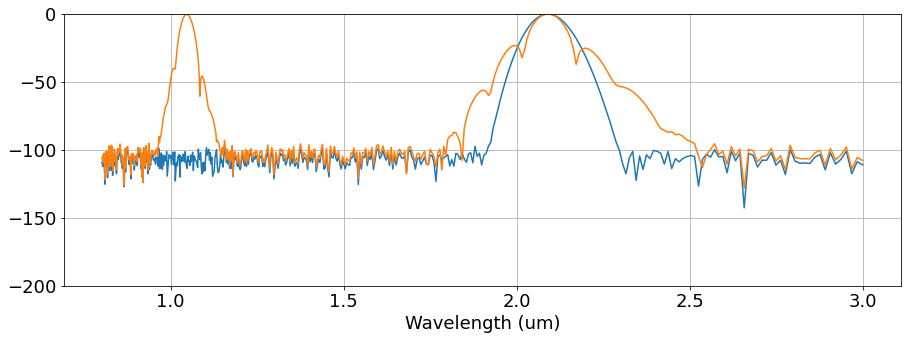

In [14]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)
pump.plot_ESD_dB_vs_wavelength(ax=ax1)
a_out.plot_ESD_dB_vs_wavelength(ax=ax1)
ax1.set_ylim([-80,0])
ax1.set_ylim([-200,0])
ax1.set_ylabel('')

## Pulse evolution along the crystal

In [15]:
#Downsample evolution for plotting
Ndown = 100
pulse_evol = pulse_evol_full[::,::Ndown]
Nsteps = pulse_evol.shape[1]-1

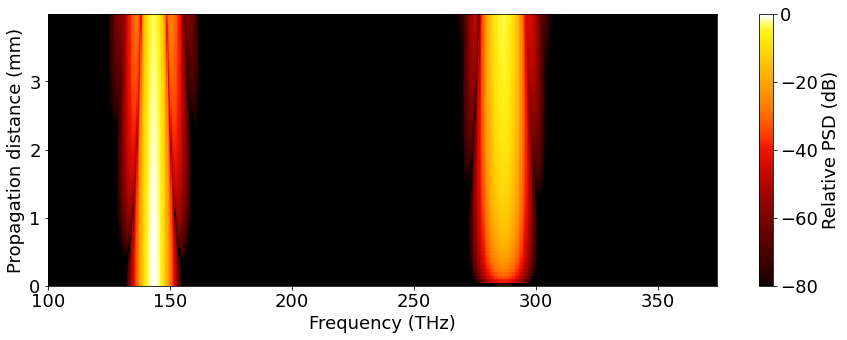

In [16]:
A_evol = np.zeros((t.size, Nsteps+1))

for k in range(Nsteps+1):
    x = pulse_evol[:,k]
    _ , Aesd = pulses.get_esd(t, x)
    A_evol[:,k] = 10*np.log10(Aesd)

A_evol = A_evol - np.amax(A_evol)
A_evol = fftshift(A_evol, axes=0)

plt.rcParams['figure.figsize'] = [15, 5]

X,Y = np.meshgrid(fftshift(f+f_ref)*1e-12, np.arange(Nsteps+1)*h*Ndown/mm)
plt.figure()
plt.pcolormesh(X, Y, (np.transpose(A_evol)), cmap = cc.cm["fire"], vmin=-80, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Frequency (THz)')
plt.ylabel('Propagation distance (mm)');

## Filtering

Text(0, 0.5, 'Pulse Amplitude (V/m)')

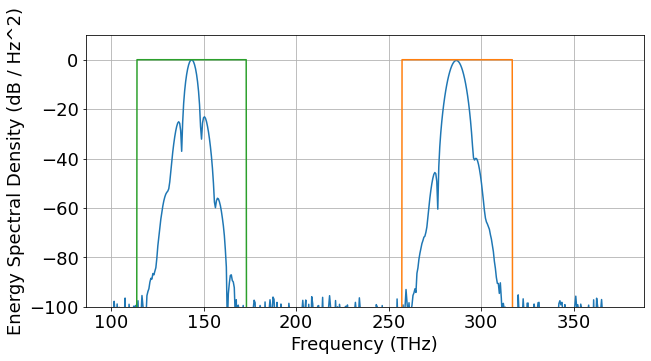

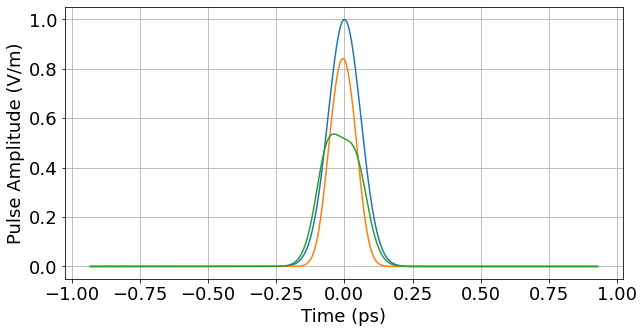

In [17]:
filter_bw = 60*THz

out_ff, h_ff = pulses.filter_signal(f_abs, fft(a_out.a), 1*f0_ff, filter_bw, type='ideal')
out_sh, h_sh = pulses.filter_signal(f_abs, fft(a_out.a), 2*f0_ff, filter_bw, type='ideal')

plt.rcParams['figure.figsize'] = [10, 5]
ax1 = a_out.plot_ESD_dB_absfreq()
ax1.plot(fftshift(f_abs)*1e-12, 20*np.log10(abs(fftshift(h_sh) + 1e-20)));
ax1.plot(fftshift(f_abs)*1e-12, 20*np.log10(abs(fftshift(h_ff) + 1e-20)))
ax1.set_ylim([-100,10])

plt.rcParams['figure.figsize'] = [10, 5]
ax1 = pump.plot_mag()
ax1 = pulses.plot_mag(t, out_sh, ax=ax1)
ax1 = pulses.plot_mag(t, out_ff, ax=ax1)
ax1.set_ylabel('Pulse Amplitude (V/m)')

# <center> END OF DOCUMENT </center>